In [8]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

In [9]:
# Function to calculate MSE and PCC
def SSIM(original, processed):
    """Calculate Mean Squared Error (MSE) and Pearson Correlation Coefficient (PCC) between two images."""
    # Apply Fourier Transform to both images
    original_ft = np.fft.fftshift(np.fft.fft2(original))
    filtered_ft = np.fft.fftshift(np.fft.fft2(processed))

    # Compute the magnitude spectra of the Fourier Transforms
    magnitude_spectrum_original = np.log(np.abs(original_ft) + 1)
    magnitude_spectrum_filtered = np.log(np.abs(filtered_ft) + 1)

    # Compute MSE
    mse_value = np.mean((magnitude_spectrum_original - magnitude_spectrum_filtered) ** 2)

    # Compute Pearson correlation
    mean1 = np.mean(magnitude_spectrum_original)
    mean2 = np.mean(magnitude_spectrum_filtered)
    numerator = np.sum((magnitude_spectrum_original - mean1) * (magnitude_spectrum_filtered - mean2))
    denominator = np.sqrt(np.sum((magnitude_spectrum_original - mean1) ** 2) *
                           np.sum((magnitude_spectrum_filtered - mean2) ** 2))
    correlation_value = numerator / denominator if denominator != 0 else 0  # Prevent division by zero

    return mse_value, correlation_value

# Apply Gaussian filter
def apply_gaussian_filter(img, sigma):
    """Apply a Gaussian filter to the image in the frequency domain."""
    # Get image size
    rows, cols = img.shape
    crow, ccol = rows // 2, cols // 2  # center

    # Perform FFT and shift
    fshift = np.fft.fftshift(np.fft.fft2(img))

    # Create a Gaussian filter
    x = np.linspace(-ccol, ccol - 1, cols)
    y = np.linspace(-crow, crow - 1, rows)
    X, Y = np.meshgrid(x, y)
    gaussian_filter = np.exp(-(X**2 + Y**2) / (2 * sigma**2))

    # Apply the Gaussian filter
    fshift_filtered = fshift * gaussian_filter
    img_back = np.fft.ifft2(np.fft.ifftshift(fshift_filtered))
    img_back = np.abs(img_back)

    return img_back

# Resize the image
def resize_image(img, target_shape):
    """Resize the image to the target shape."""
    return cv2.resize(img, (target_shape[1], target_shape[0]))

# Mouse callback function to capture the rectangle coordinates
def draw_rectangle(event, x, y, flags, param):
    global rectangles, ix, iy, drawing, region
    
    if event == cv2.EVENT_LBUTTONDOWN:
        ix, iy = x, y
        drawing = True
    
    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing:
            img_copy = region.copy()
            cv2.rectangle(img_copy, (ix, iy), (x, y), (255, 0, 0), 2)
            cv2.imshow("Select Rectangles", img_copy)
    
    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        rectangles.append((ix, iy, x - ix, y - iy))
        cv2.rectangle(region, (ix, iy), (x, y), (255, 0, 0), 2)
        cv2.imshow("Select Rectangles", region)

# Function to apply the mask on the selected rectangle
def apply_mask(image, x, y, w, h):
    # Create a rectangular mask
    canvas = np.zeros_like(image)
    
    # Check if the mask dimensions fit within the image boundaries
    if x + w <= image.shape[1] and y + h <= image.shape[0]:
        canvas[y:y + h, x:x + w] = 1
    else:
        raise ValueError("The mask exceeds the image boundaries")

    # Apply the mask and binarize
    mask = np.array(canvas) * image
    
    # Apply binarization based on the threshold
    for j in range(y, y + h):
        for i in range(x, x + w):
            mask[j, i] = 0 if mask[j, i] >= 150 else 128

    return mask

# Function to apply a kernel to the image
def apply_kernel(image, kernel):
    """
    Applies the given kernel to the image.
    
    Parameters:
    image (np.array): The input image in NumPy array format.
    kernel (np.array): The kernel to apply to the image.
    
    Returns:
    processed_image (np.array): The image after applying the kernel.
    """
    # If the image is grayscale (single channel), skip conversion
    if len(image.shape) == 3:  # Check if image has 3 channels
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray_image = image  # Already grayscale

    # Apply the kernel to the grayscale image
    processed_image = cv2.filter2D(gray_image, -1, kernel)
    
    return processed_image

def apply_filter_bandpass(image, low_cutoff, high_cutoff, locate_x, locate_y, mask_shape):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    f_transform = np.fft.fft2(image)
    f_transform_shifted = np.fft.fftshift(f_transform)

    rows, cols = image.shape
    crow, ccol = rows // locate_x, cols // locate_y

    mask = np.zeros((rows, cols), dtype=np.uint8)

    if mask_shape == 'c':
        for i in range(rows):
            for j in range(cols):
                distance = np.sqrt((i - crow) ** 2 + (j - ccol) ** 2)
                if low_cutoff < distance < high_cutoff:
                    mask[i, j] = 1

    elif mask_shape == 'r':
        low_x, high_x = crow - low_cutoff, crow + high_cutoff
        low_y, high_y = ccol - low_cutoff, ccol + high_cutoff
        mask[low_x:high_x, low_y:high_y] = 1

    elif mask_shape == 's':
        for i in range(rows):
            for j in range(cols):
                if ((abs(i - crow) < high_cutoff and abs(j - ccol) < low_cutoff) or 
                    (abs(i - crow) < low_cutoff and abs(j - ccol) < high_cutoff)):
                    mask[i, j] = 1

    else:
        raise ValueError("Invalid mask shape. Use 'c' for circle, 'r' for rectangle, or 's' for star.")

    filtered_transform = f_transform_shifted * mask

    f_ishifted = np.fft.ifftshift(filtered_transform)
    filtered_image = np.fft.ifft2(f_ishifted)
    filtered_image = np.abs(filtered_image)

    return filtered_image, mask


# Lenna

Sigma: 5, MSE: 56.30775041891038, PCC: 0.25755692613062525
Sigma: 6, MSE: 56.05422531489082, PCC: 0.29015601637606214
Sigma: 7, MSE: 55.77309018394807, PCC: 0.31978741969001245
Sigma: 8, MSE: 55.46745951459509, PCC: 0.3468943755499853
Sigma: 9, MSE: 55.13113426420196, PCC: 0.3728163928093043
Sigma: 10, MSE: 54.76711992159695, PCC: 0.3974916978693165
Sigma: 11, MSE: 54.38005349919736, PCC: 0.42065415020184227
Sigma: 12, MSE: 53.97205235886412, PCC: 0.4422721151223023
Sigma: 13, MSE: 53.54369325869165, PCC: 0.46250533189806725
Sigma: 14, MSE: 53.09374930034987, PCC: 0.48168000173312153
Sigma: 15, MSE: 52.62179323196859, PCC: 0.5000266975569913
Sigma: 16, MSE: 52.12855688317914, PCC: 0.5176331629236028
Sigma: 17, MSE: 51.61414384501653, PCC: 0.5345790078994598
Sigma: 18, MSE: 51.07877835770964, PCC: 0.550922030299214
Sigma: 19, MSE: 50.52349190866895, PCC: 0.5666753525860116
Sigma: 20, MSE: 49.949351405012585, PCC: 0.5818421083163124
Sigma: 21, MSE: 49.35717646468782, PCC: 0.5964211647556

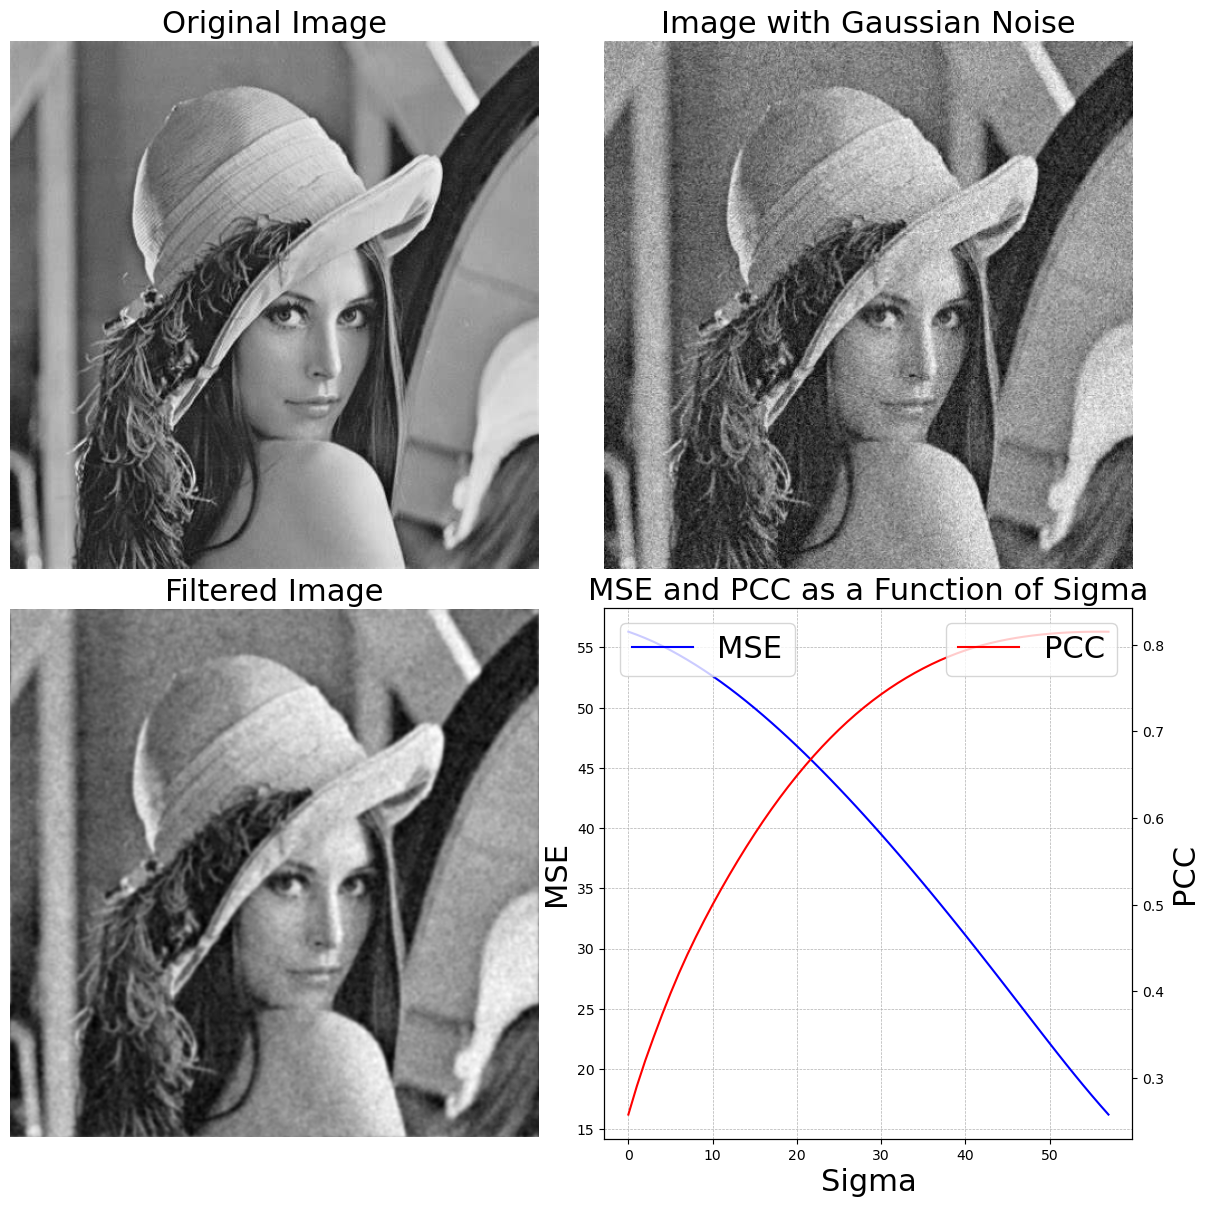

In [10]:
# Load images
lenna_original = cv2.imread('Img\\lenna_color.jpg', cv2.IMREAD_GRAYSCALE)
lenna_gauss = cv2.imread('Img\\lenna_gauss.png', cv2.IMREAD_GRAYSCALE)

# Resize the image with Gaussian noise
lenna_gauss = resize_image(lenna_gauss, lenna_original.shape)

# Parameter initialization
sigma = 5  # Initial sigma value for the Gaussian filter
step = 1   # Step to increase or decrease sigma
mse_value, pcc_value = SSIM(lenna_original, lenna_gauss)

# Lists to store MSE and PCC values
mse_list = []
pcc_list = []
pcc_best = 0

# Loop to minimize the MSE
while True:
    # Apply Gaussian filter
    lenna_filtered = apply_gaussian_filter(lenna_gauss, sigma)

    # Calculate MSE and PCC
    mse_value, pcc_value = SSIM(lenna_original, lenna_filtered)

    # Store the values
    mse_list.append(mse_value)
    pcc_list.append(pcc_value)

    # Display the values
    print(f'Sigma: {sigma}, MSE: {mse_value}, PCC: {pcc_value}')

    # Adjust sigma based on the PCC
    if pcc_value > pcc_best:
        pcc_best = pcc_value
        sigma += step
    else:
        break  # Break the loop if the MSE is zero or negative

# Plot results
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Original image
axs[0, 0].imshow(lenna_original, cmap='gray')
axs[0, 0].set_title('Original Image', fontsize=22)  # Increase title size
axs[0, 0].axis('off')

# Image with Gaussian noise
axs[0, 1].imshow(lenna_gauss, cmap='gray')
axs[0, 1].set_title('Image with Gaussian Noise', fontsize=22)  # Increase title size
axs[0, 1].axis('off')

# Filtered image
axs[1, 0].imshow(lenna_filtered, cmap='gray')
axs[1, 0].set_title('Filtered Image', fontsize=22)  # Increase title size
axs[1, 0].axis('off')

# Plot MSE and PCC
axs[1, 1].plot(mse_list, label='MSE', color='blue')
axs[1, 1].set_ylabel('MSE', fontsize=22)  # Y-axis label for MSE
#axs[1, 1].set_yscale('log')  # Set y-axis for MSE to logarithmic scale

# Create a second Y-axis for PCC
ax2 = axs[1, 1].twinx()  # Create a second y-axis
ax2.plot(pcc_list, label='PCC', color='red')
ax2.set_ylabel('PCC', fontsize=22)  # Y-axis label for PCC

# Set common title and labels
axs[1, 1].set_title('MSE and PCC as a Function of Sigma', fontsize=22)  # Increase title size
axs[1, 1].set_xlabel('Sigma', fontsize=22)  # Increase x-axis label size

# Add a grid for better readability
axs[1, 1].grid(True, which="both", ls="--", linewidth=0.5)

# Add a legend to the plot
axs[1, 1].legend(loc='upper left', fontsize=22)  # Increase legend size for MSE
ax2.legend(loc='upper right', fontsize=22)  # Legend for PCC on the second Y-axis

# Adjust the layout automatically
fig.tight_layout(pad=0.4)  # Adjust the space between subplots
plt.show()


# Newspaper

Sigma: 100, MSE: 14.593344792973216, PCC: 0.7683543088384288
Sigma: 110, MSE: 10.2253875241984, PCC: 0.7935844919684244
Sigma: 120, MSE: 7.287962628687041, PCC: 0.8189794979268713
Sigma: 130, MSE: 5.31150948887216, PCC: 0.84249713134554
Sigma: 140, MSE: 3.9559930160427403, PCC: 0.8635625445209592
Sigma: 150, MSE: 3.0047872280658954, PCC: 0.8821070811725433
Sigma: 160, MSE: 2.3224127774765213, PCC: 0.8982521707410772
Sigma: 170, MSE: 1.8229547072072658, PCC: 0.9122010094541704
Sigma: 180, MSE: 1.4507210871029532, PCC: 0.9241890293438796
Sigma: 190, MSE: 1.1687774199109386, PCC: 0.9344565386265951
Sigma: 200, MSE: 0.9520927877905704, PCC: 0.9432330400515467
Sigma: 210, MSE: 0.7833615680162201, PCC: 0.9507288412502957
Sigma: 220, MSE: 0.6503991505985361, PCC: 0.957131378476818
Sigma: 230, MSE: 0.5444828248108721, PCC: 0.9626044981488423
Sigma limit: 230


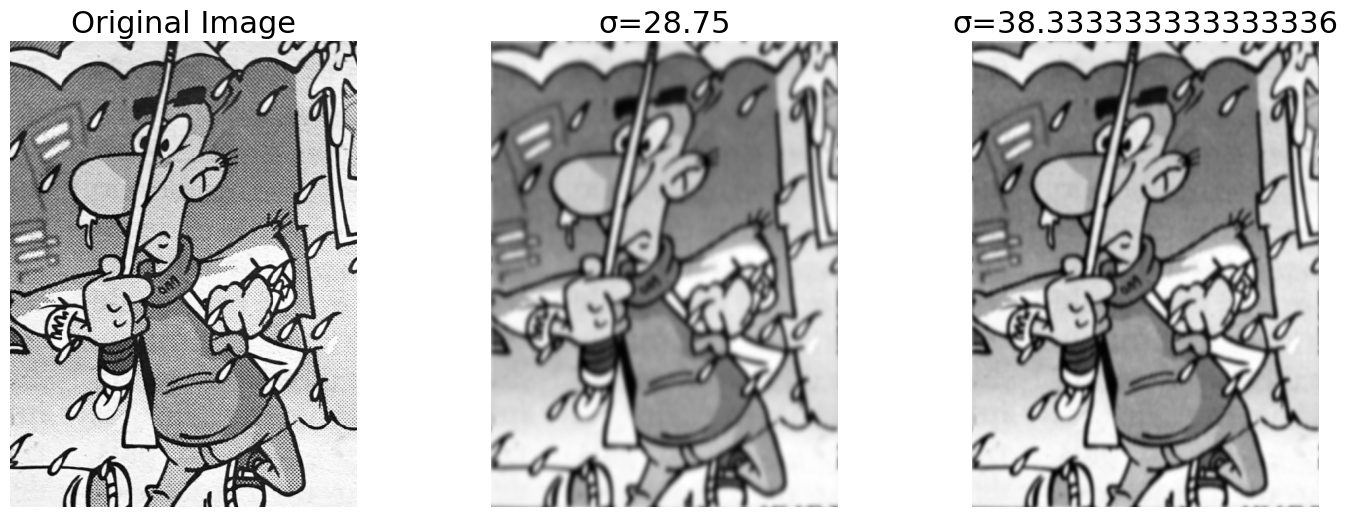

In [11]:
# Load the cartoon image
cartoon = cv2.imread('Img\\cartoon.jpg', cv2.IMREAD_GRAYSCALE)


# Find sigma limit, MSE = 0 and PCC = 0
sigma_limit = 100

while True:
    # Calculate MSE and PCC
    filtered_limit = apply_gaussian_filter(cartoon, sigma_limit)
    mse_value, pcc_value = SSIM(cartoon, filtered_limit)
    print(f'Sigma: {sigma_limit}, MSE: {mse_value}, PCC: {pcc_value}')
    if mse_value > 0.001 and pcc_value < 0.96:
        sigma_limit += 10
    else:
        break

print(f'Sigma limit: {sigma_limit}')

# Apply Gaussian filters with different sigma values
sigma1 = sigma_limit/8  # First sigma value for Gaussian filter
sigma2 = sigma_limit/6  # Second sigma value for Gaussian filter

filtered_image1 = apply_gaussian_filter(cartoon, sigma1)
filtered_image2 = apply_gaussian_filter(cartoon, sigma2)

# Plot results
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Original image
axs[0].imshow(cartoon, cmap='gray')
axs[0].set_title('Original Image', fontsize=22)  # Increase title size to 18
axs[0].axis('off')

# Filtered image 1
axs[1].imshow(filtered_image1, cmap='gray')
axs[1].set_title(f'σ={sigma1}', fontsize=22)  # Increase title size to 18
axs[1].axis('off')

# Filtered image 2
axs[2].imshow(filtered_image2, cmap='gray')
axs[2].set_title(f'σ={sigma2}', fontsize=22)  # Increase title size to 18
axs[2].axis('off')

# Adjust the layout automatically
fig.tight_layout(pad=0.1)
plt.show()

# 20-Peso Bill

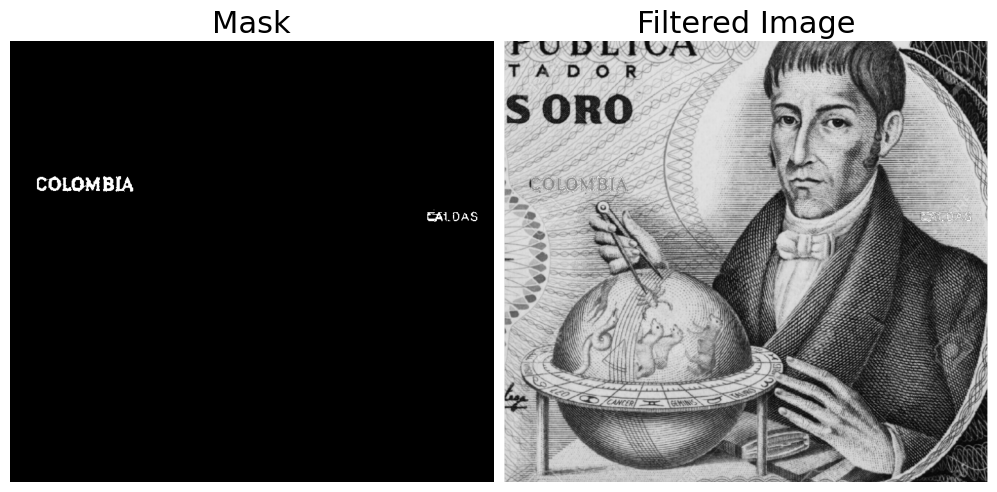

In [12]:
# Load the image and convert it to grayscale
bill_original = np.array(Image.open('Img/bill.png').convert("L"))

# Global variable to store the selected rectangles
rectangles = []
drawing = False  # Variable to indicate if the mouse is being dragged
ix, iy = -1, -1  # Initial mouse coordinates

# Display the image and let the user select rectangles
region = cv2.imread('Img/bill.png')
cv2.imshow("Select Rectangles", region)
cv2.setMouseCallback("Select Rectangles", draw_rectangle)

# Wait until the user presses the 'q' key to finish selecting rectangles
while True:
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

cv2.destroyAllWindows()

# Create and combine masks from user-selected rectangles
mask = np.zeros_like(bill_original)
for rect in rectangles:
    x, y, w, h = rect
    mask += apply_mask(bill_original, x, y, w, h)

# Apply the Fourier Transform
ft_mask = np.fft.fftshift(np.fft.fft2(mask))
ft_bill_original = np.fft.fftshift(np.fft.fft2(bill_original))
filtered_ft = ft_bill_original + ft_mask

# Inverse Fourier Transform
ift_result = np.abs(np.fft.ifft2(np.fft.ifftshift(filtered_ft)))

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the mask
axs[0].imshow(mask, cmap='gray')
axs[0].set_title('Mask', fontsize=22)  # Increase title size to 22
axs[0].axis('off')  # Turn off axis labels

# Plot the IFT result
axs[1].imshow(ift_result, cmap='gray')
axs[1].set_title('Filtered Image', fontsize=22)  # Increase title size to 22
axs[1].axis('off')  # Turn off axis labels

# Adjust layout
fig.tight_layout(pad=0.8)  # Adjust the space between subplots
plt.show()

# Xilography

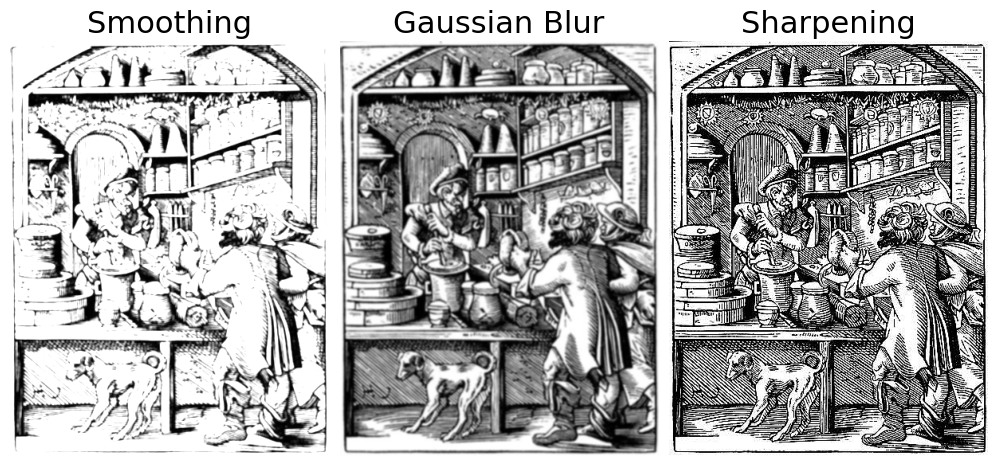

In [13]:
# Load the xilography image
image = np.array(Image.open('Img\\xilography_image.jpg').convert("L"))  # Replace with your file path

# Kernel 1: Box Blur (Smoothing Kernel)
# This kernel averages the values of the pixel and its neighbors to smooth the image.
box_blur_kernel = np.array([[1, 1, 1],
                            [1, 1, 1],
                            [1, 1, 1]]) / 4

# Kernel 2: Gaussian Blur
# This applies a Gaussian-weighted blur to smooth the image with less noise.
gaussian_blur_kernel = cv2.getGaussianKernel(5, 0) @ cv2.getGaussianKernel(5, 0).T

# Kernel 3: Sharpening Kernel
# This kernel enhances edges and fine details by emphasizing differences between a pixel and its neighbors.
random_kernel = np.array([[0, -1, 0],
                           [-1, 5, -1],
                           [0, -1, 0]])

# Apply kernels
box_blur_image = apply_kernel(image, box_blur_kernel)
gaussian_blur_image = apply_kernel(image, gaussian_blur_kernel)
sharpen_image = apply_kernel(image, random_kernel)

# Display processed images
fig, ax = plt.subplots(1, 3, figsize=(10, 5))

ax[0].imshow(box_blur_image, cmap='gray')
ax[0].set_title('Smoothing', fontsize=22)  # Increase title size to 18
ax[0].axis('off')

ax[1].imshow(gaussian_blur_image, cmap='gray')
ax[1].set_title('Gaussian Blur', fontsize=22)  # Increase title size to 18
ax[1].axis('off')

ax[2].imshow(sharpen_image, cmap='gray')
ax[2].set_title('Sharpening', fontsize=22)  # Increase title size to 18
ax[2].axis('off')

fig.tight_layout(pad=0.8)  # Adjust the space between subplots
plt.show()


# Map

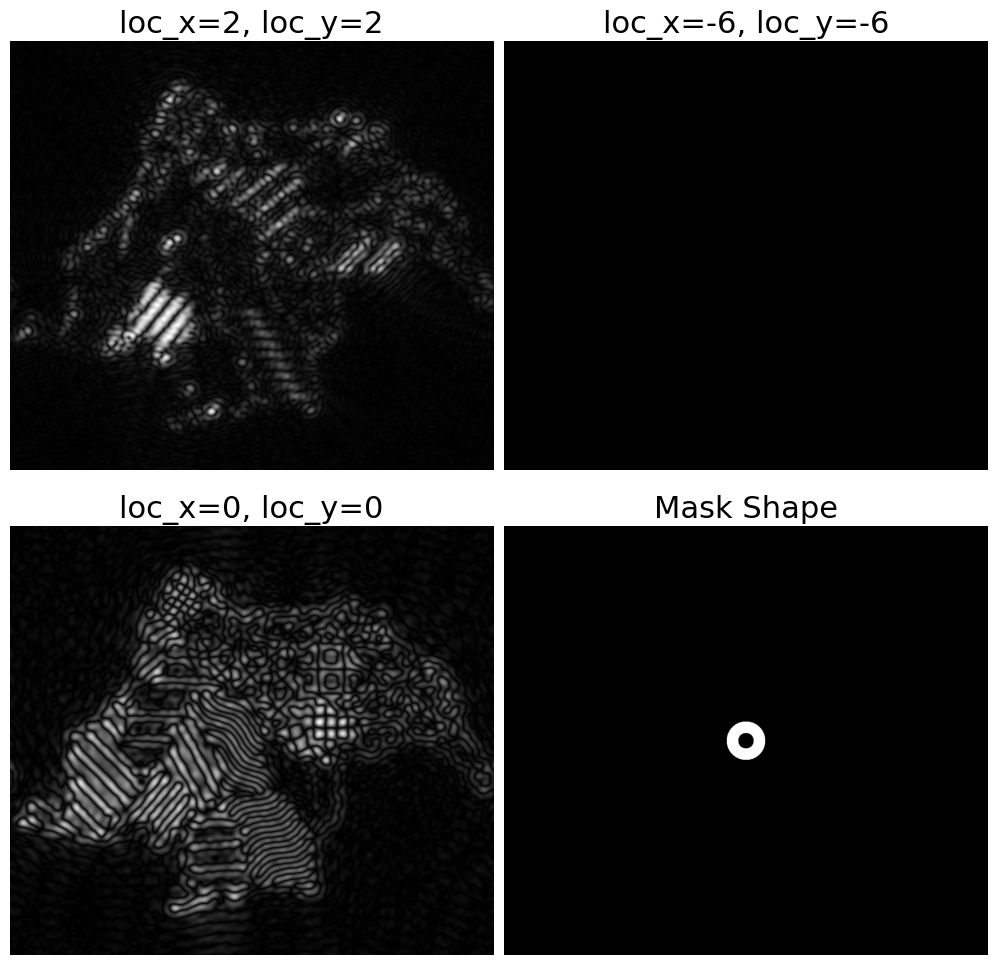

In [14]:


# Load the map image
Map = cv2.imread('Img\\Mapa_Colombia.jpg', cv2.IMREAD_GRAYSCALE)

# Set frequency ranges (adjust as needed)
low_cutoff = 20
high_cutoff = 50

n = 3  # Number of random iterations

# Lists to store the filtered images and masks
locate = [[4, 4],[-4, -4],[2, 2]]
filtered_images = []
masks = []
titles = []

# Loop for n random changes in locate_x and locate_y
for i in range(n):
    # Randomly generate locate_x and locate_y values
    # locate_x = np.random.randint(2, 10)
    # locate_y = np.random.randint(2, 10)
    locate_x = locate[i][0]
    locate_y = locate[i][1]
    
    # Apply the filter
    filtered_image, mask = apply_filter_bandpass(Map, low_cutoff, high_cutoff, locate_x, locate_y, 'c')
    
    # Store the results
    filtered_images.append(filtered_image)
    masks.append(mask)
    titles.append(f'loc_x={locate_x-2}, loc_y={locate_y-2}')

# Display all the results at the end, 2 images per row
num_images = len(filtered_images)
plt.figure(figsize=(10, 5 * (num_images // 2 + num_images % 2)))  # Adjust figure height based on number of images

for i in range(num_images):
    # Display filtered image
    plt.subplot(num_images // 2 + num_images % 2, 2, i + 1)
    plt.title(f'{titles[i]}', fontsize=22)
    plt.imshow(filtered_images[i], cmap='gray')
    plt.axis('off')

    # Display mask
    plt.subplot(num_images // 2 + num_images % 2, 2, i + 2)
    plt.title(f'Mask Shape', fontsize=22)
    plt.imshow(masks[i], cmap='gray')
    plt.axis('off')

plt.tight_layout(pad=0.8)
plt.show()


